In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! pip install transformers[torch] datasets accelerate

## 1. Imports

In [5]:
# For general data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
import matplotlib.pyplot as plt

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, logging

# to convert to dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU.")

In [6]:
df = pd.read_csv('drive/MyDrive/sample_data_for_task1.csv')

In [45]:
df.shape

(37295, 2)

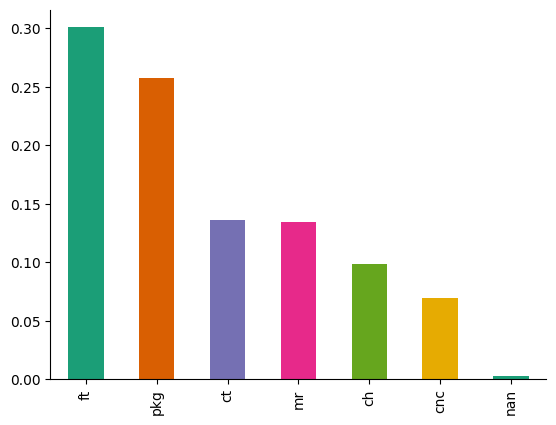

In [47]:
from matplotlib import pyplot as plt
import seaborn as sns
df['label'].value_counts(normalize=True,dropna=False).plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
# df.groupby('label').size().sort_values().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Interpretation

1. `ft` class has the highest number of queries followed by `pkg` and `ct`.
2. Some queries do not have label. We will remove them since they can't be used for training.

## 2. Data Processing

In [44]:
# check if there are non german characters in the query
import string
chars = string.ascii_lowercase + 'äöüß'
df[~df['text'].str.lower().str.contains('|'.join(char for char in chars), regex=True)].sample(5)

,text,label
27604,,ch
10339,,cnc
30220,04025440209,ch
15944,吉祥,pkg
19174,,ct


In [11]:
# remove cases like test88@mail.com
df=df[~df['text'].str.contains(r'test\d+', regex=True)]
# remove cases like 04025440183
df = df[~df['text'].str.isdigit()].copy()
# remove queries which empty strings and non english characters, drop cases where text or label is NA
df=df[~df['text'].isin([' ','吉祥'])].drop_duplicates().dropna()

In [12]:
label_map = {'ft':0, 'mr':1, 'ct':2, 'pkg':3, 'ch':4, 'cnc':5}
df['label_int']=df['label'].map(label_map)

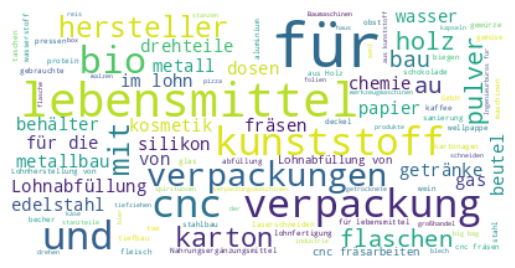

In [14]:
from wordcloud import WordCloud

text  = " ".join(query for query in df.text)

wordcloud = wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## 3. Model Training

In [17]:
# create training, validation and test split using stratified sampling.
train_df, validation_df = train_test_split(df[['text', 'label_int']],
                                    test_size = 0.3, random_state = 42, stratify = df['label_int'])

val_df, test_df = train_test_split(validation_df[['text', 'label_int']],
                                    test_size = 0.1, random_state = 42, stratify = validation_df['label_int'])

In [18]:
train_df.shape,val_df.shape,test_df.shape

((24360, 2), (9396, 2), (1045, 2))

In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
tokenized_train = pipeline(train_df)
tokenized_val = pipeline(val_df)

tokenized_train = tokenized_train.rename_column("label_int", "label")
tokenized_val = tokenized_val.rename_column("label_int", "label")

Map:   0%|          | 0/24360 [00:00<?, ? examples/s]

Map:   0%|          | 0/9396 [00:00<?, ? examples/s]

In [23]:
# ensure text padding and length is consistent
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# load the pretrained model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)
# setup training parameters to train the last layer
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    weight_decay=0.01,
    report_to="none",
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# takes 16mins to train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,1.067600
1000,0.538600
1500,0.424400
2000,0.305900
2500,0.282500
3000,0.265700
3500,0.183400
4000,0.197400
4500,0.191500
5000,0.139500


TrainOutput(global_step=9138, training_loss=0.24011305683575984, metrics={'train_runtime': 1000.2286, 'train_samples_per_second': 146.127, 'train_steps_per_second': 9.136, 'total_flos': 1430302507977312.0, 'train_loss': 0.24011305683575984, 'epoch': 6.0})

In [ ]:
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns(['label_int'])
preds = trainer.predict(tokenized_test)

preds_flat = [np.argmax(x) for x in preds[0]]

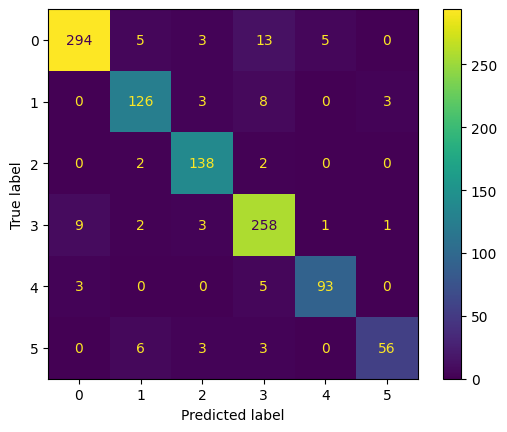

In [27]:
cm = confusion_matrix(test_df['label_int'], preds_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [30]:
precision, recall, fscore, support = score(test_df['label_int'], preds_flat)
output_df=pd.DataFrame({'precision':precision,
                        'recall': recall,
                        'fscore': fscore,
                        'label': ['ft', 'mr', 'ct', 'pkg', 'ch' , 'cnc']
                        })

<Axes: xlabel='label'>

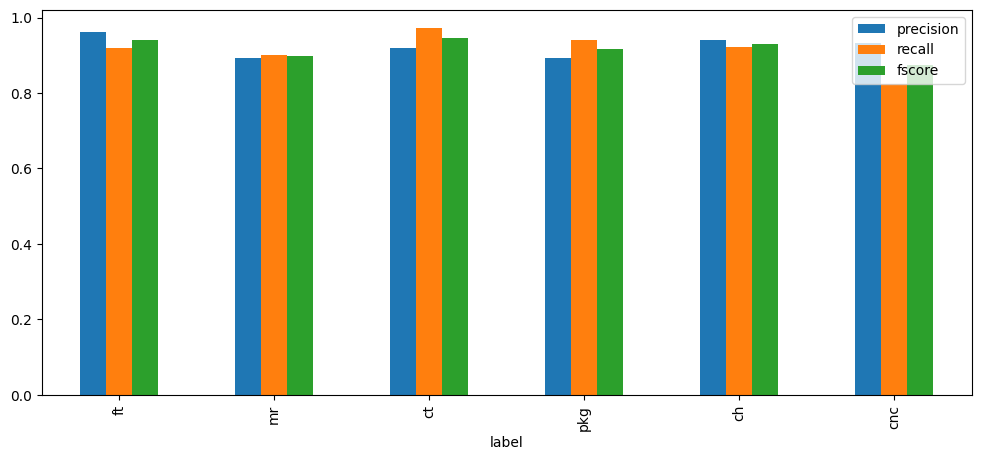

In [35]:
output_df.set_index('label').plot(kind='bar', figsize=(12, 5))

### Interpretation

1. We find the average F1 score over different classes is around 0.89.
2. Also, we find that the model is performing decently well across all different classes.
3. Confusion matrix gives us a better picture of the cases where model is doing misclassifications.

In [36]:
# check queries where model is giving incorrect predictions
test_df['pred_class'] = preds_flat
sorted(test_df.query('label_int != pred_class')['text'].values)[::2]

['Additiv Kunststoff',
 'Belegtaschen für Lackierwagen',
 'Chateau de Grave Cabernet sauvignon',
 'Drahterodierung arbeiten',
 'Fassadenanstrichfarben (Schutzanstriche) für Putze',
 'Gefriertrocknung von Früchten',
 'Lohnabfüllung von brennstoff',
 'Räucherlachs geschnitten',
 'Sondermaschinenbau für Lebensmittel',
 'Vorschubbänder für Schleifmaschinen',
 'Wein Flaschenverschluss',
 'abfüller honig',
 'aluminium Fertigungsteile',
 'arbeiten reihenbohrmaschinen',
 'bearbeitungszentrum für Schweißteile',
 'bodenschleifmaschinen mietten',
 'cola dosen',
 'decke bohnen',
 'drehen fräsen bohren',
 'einpackung für carports aus holz leinen',
 'getränkesieb für fische',
 'holz aufsparendämmung',
 'isoliertasche pizza',
 'karabinerhaken mit kunststoff clip',
 'konservierungsmittel für nutzfahrzeuge',
 'krappen mit Schale',
 'kunststoff zerspanungstechnik',
 'köhler königsbach',
 'lebensmittel metallkanister',
 'lohnabfüllung von ampullen für chemische lösungen',
 'minirohre für den kabelschutz'

In [39]:
# save model for serving
output_dir = "./search_query_trainer"
trainer.save_model(output_dir)